In [1]:
!pip install plotly
!pip install umap-learn

In [2]:
!jupyter labextension install jupyterlab-plotly

(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
Building jupyterlab assets (production, minimized)


In [3]:
!jupyter labextension list

JupyterLab v3.6.1
/opt/conda/share/jupyter/labextensions
        jupyterlab_pygments v0.2.2 enabled OK (python, jupyterlab_pygments)
        jupyterlab-plotly v5.13.1 enabled OK
        jupyter-matplotlib v0.11.2 enabled OK
        @jupyter-widgets/jupyterlab-manager v5.0.5 enabled OK (python, jupyterlab_widgets)

Other labextensions (built into JupyterLab)
   app dir: /opt/conda/share/jupyter/lab



In [4]:
import scipy.stats as stats

import pandas as pd
from sklearn.datasets import make_blobs

import plotly.graph_objects as go

import matplotlib.pyplot as plt # Para crear gráficos con matplotlib
import plotly as py
import plotly.io as pio

In [3]:
pio.renderers.default = 'iframe'

In [561]:
# Simulación de datos
# ==============================================================================
X, y = make_blobs(
        n_samples    = 600, 
        n_features   = 2, 
        centers      = 3, 
        cluster_std  = 1, 
        shuffle      = True, 
        random_state = 0
       )

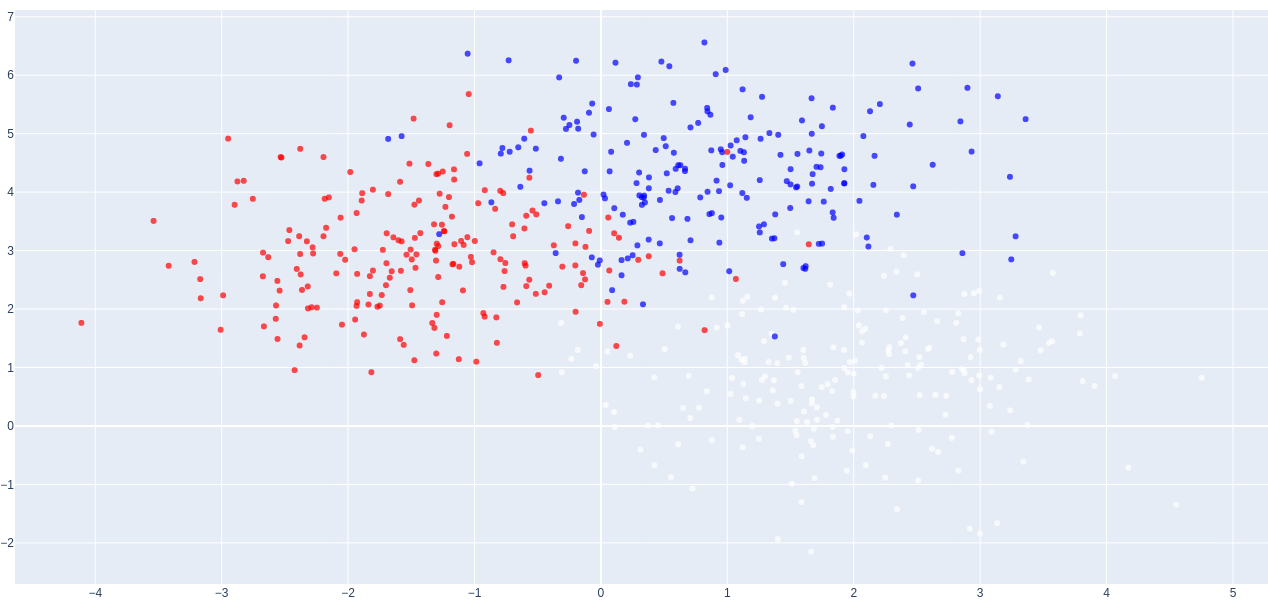

In [562]:
fig = go.Figure(data=[go.Scatter(x=X[:, 0], y=X[:, 1],
                                   mode='markers', 
                                   marker=dict(
                                    size=6,
                                    color=y,                # set color to an array/list of desired values
                                    colorscale='picnic',   # choose a colorscale
                                    opacity=0.7)
                                  )])

fig.update_layout(
    autosize=False,
    width=600,
    height=600,
    margin=dict(l=0, r=0, b=0, t=10))
    
fig.show()

In [574]:
%run frontera_v2.ipynb

In [575]:
frontera = Frontera(X,y,percentil_min=5, percentil_max=20, N_points_frontera=41)

In [576]:
%%time
frontera.get_frontier()



CPU times: user 63.2 ms, sys: 243 ms, total: 306 ms
Wall time: 29.6 ms


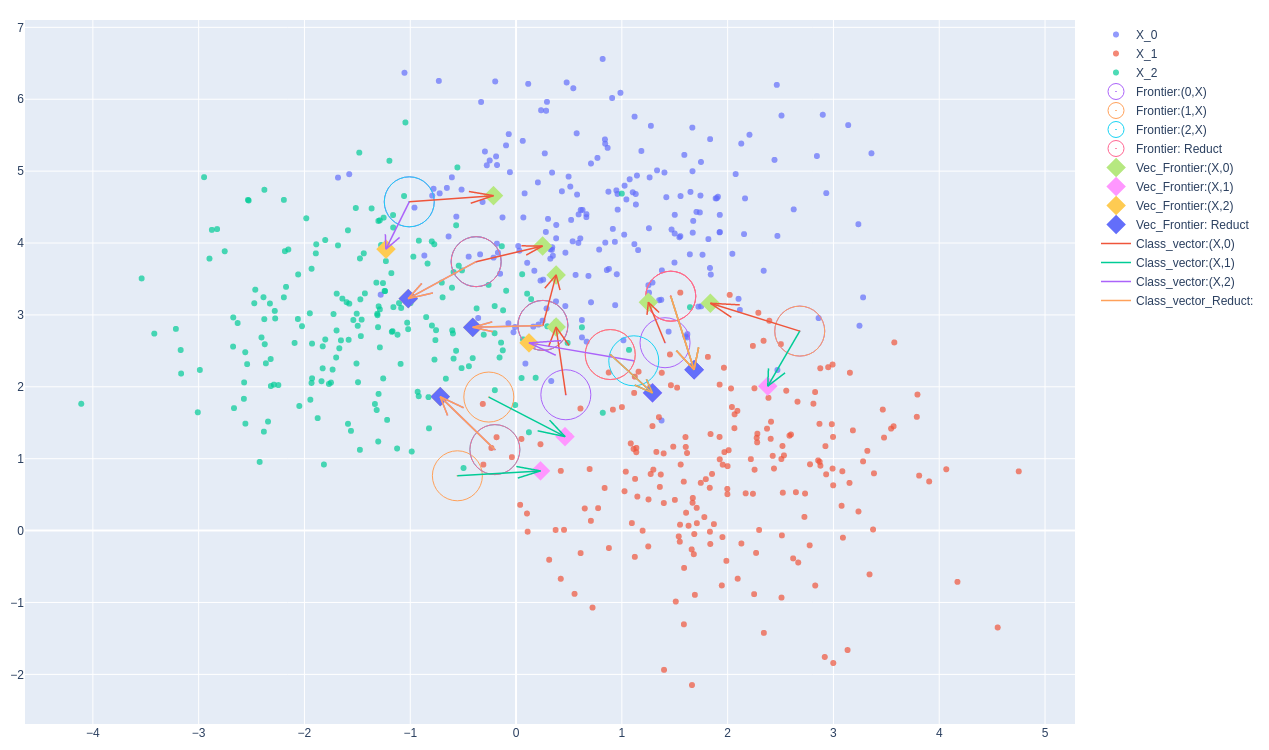

In [577]:
frontera.plot_Vectors(0,1)

In [401]:
#frontera.plot_frontera_2D(0,1)

In [16]:
frontera.plot_muestra_2D(0,1)

In [400]:
# graph tsne
frontera.class_vector

{'Class_vector:(X,0)': array([[ 3.75815691e-04,  2.40296890e+00,  1.33922547e-01,
          6.00493366e-01],
        [-2.62318617e-01,  3.43294366e+00,  5.54138435e-01,
          5.39915713e-01],
        [ 2.03132365e+00,  2.54715870e+00, -5.89391129e-01,
          6.57227835e-01],
        [ 9.25470422e-01,  2.56351014e+00,  2.96046579e-01,
          6.44046040e-01]]),
 'Class_vector:(X,1)': array([[ 1.42328643,  3.13844365,  0.01318337, -0.61260133],
        [ 0.31772646,  2.04277388,  0.54673209, -0.62022468],
        [-0.42853342,  0.83275547,  1.11381679,  0.12262173]]),
 'Class_vector:(X,2)': array([[ 0.15154639,  2.67579411, -0.90849232,  0.05096388],
        [-0.58579431,  3.94122941, -0.36820382, -0.59828235],
        [-0.24202585,  1.54473659, -0.59110501,  0.48223059]])}

In [399]:
import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

A = np.array(
[[0, 1, 0, 0, 1],
[0, 0, 1, 1, 1],
[1, 1, 0, 1, 0]])


A = np.array(
[[1, 0, 0],
 [-1, 0, 0],
[0, 1, 0],
[0, 0, 1]])


dist_out = 1-pairwise_distances(A, metric="cosine")
dist_out

array([[ 1., -1.,  0.,  0.],
       [-1.,  1.,  0.,  0.],
       [ 0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.]])

In [396]:
from numpy.linalg import norm
# define two lists or array
A = np.array([0, 1, 0, 0, 1])
B = np.array([0, 0, 1, 1, 1])
 
print("A:", A)
print("B:", B)
 
# compute cosine similarity
cosine = np.dot(A,B)/(norm(A)*norm(B))
cosine

A: [0 1 0 0 1]
B: [0 0 1 1 1]


0.40824829046386296

In [55]:
K = np.matrix([4,5,8,96,45]) < 5
K

matrix([[ True, False, False, False, False]])

In [62]:
not np.any(K == True)

False

In [26]:
frontera.Frontier_Point.get('Frontier:(0,1)').shape[1]

2

In [252]:
def distance(x0,x1):

    # X=(200,3) ; Y=(150,3)
    # diag(X*X')              <> (200,3) * (3,200) > diag(200,200) > (200,1)            X^2   (X-Y)^2
    # 2*X*Y'                  <>(200,3) * (3,150) > (200,150)                          -2XY
    # ones(N,1)*(diag(Y*Y'))' <> (200,1) * (150,1)' > (200,1) * (1,150) >(200,150)      Y^2
    # M_distance = diag(X*X')-2*X*Y'+ones(N,1)*(diag(Y*Y'))'  %%MATLAB
    M_distance = np.reshape( 
        np.diag(np.dot(x0,x0.T)),(-1,1)) - 2*np.dot(x0,x1.T) + np.dot( np.ones((x0.shape[0],1)), np.reshape(np.diag( np.dot(x1,x1.T)).T,(1,-1)) )
    return M_distance

In [88]:
for categories in list(comb_categories):

    dist = self.distance(self.dic_categorias.get(categories[0]), self.dic_categorias.get(categories[1]))

    # row
    row = np.mean(dist, axis=1)
    select_indices_row = np.where( 
        (row > np.percentile(row, self.percentil_min)) & (row < np.percentile(row, self.percentil_max)) )[0]
    min_dst_row = self.dic_categorias.get(categories[0])[select_indices_row]
    dic_min_dst_aux ={categories[0]+'_with_'+categories[1]:min_dst_row} 
    self.dic_min_dst.update(dic_min_dst_aux)

    #Column
    column = np.mean(dist, axis=0)
    select_indices_column = np.where( 
        (column > np.percentile(column, self.percentil_min)) & (column < np.percentile(column, self.percentil_max)) )[0]
    min_dst_column = self.dic_categorias.get(categories[1])[select_indices_column]
    dic_min_dst_aux ={categories[1]+'_with_'+categories[0]:min_dst_column} 
    self.dic_min_dst.update(dic_min_dst_aux)

In [19]:
frontera.dic_min_dst.get(A_with_B).shape[1]

NameError: name 'A_with_B' is not defined

In [255]:
Frontier_Point = {}

list_all_frontier = [key for key in frontera.dic_min_dst]
print(list_all_frontier[0])
list_A_with_B = [nombre for indice, nombre in enumerate(list_all_frontier) if indice%2==0]
list_B_with_A = [nombre for indice, nombre in enumerate(list_all_frontier) if indice%2==1]

for A_with_B, B_with_A in zip(list_A_with_B, list_B_with_A): #obtenemos los valores en cada iteración
    dist = distance(frontera.dic_min_dst.get(A_with_B), frontera.dic_min_dst.get(B_with_A))
    
    #ROW
    min_dist_A_with_B = np.where( dist==np.min(dist) )[0]
    min_A_with_B = frontera.dic_min_dst.get(A_with_B)[min_dist_A_with_B]
    dd = np.delete(frontera.dic_min_dst.get(A_with_B), min_dist_A_with_B, axis=0)
    print(dd.shape)
    #COLUMN
    min_dist_B_with_A = np.where( dist==np.min(dist) )[1]
    min_B_with_A = frontera.dic_min_dst.get(B_with_A)[min_dist_B_with_A]
    
    Point = (np.mean(min_A_with_B+min_B_with_A,axis=0))/2
    Front_Point ={'Frontier:(' + B_with_A.split('_')[-1] + ',' + A_with_B.split('_')[-1] + ')' : Point} 
    Frontier_Point.update(Front_Point)
    
    
    
print(Frontier_Point)


X_0_with_X_1
(19, 2)
(19, 2)
(19, 2)
{'Frontier:(0,1)': array([-0.07559779,  2.16961034]), 'Frontier:(0,2)': array([-0.92539358,  4.65651519]), 'Frontier:(1,2)': array([-0.4413335 ,  0.66878828])}


In [132]:
list_B[0]

'X_1_with_X_0'

In [139]:
list_B[0].split('_')[-1]

'0'

In [45]:
for key, value_dst in frontera.dic_min_dst.items():
    print(key)
    

X_0_with_X_1
X_1_with_X_0
X_0_with_X_2
X_2_with_X_0
X_1_with_X_2
X_2_with_X_1


In [36]:
#dic_categorias.get('X_0')

In [20]:
categorias_list = [key for key in dic_categorias]
categorias_list.append('X_')
categorias_list

NameError: name 'dic_categorias' is not defined

In [139]:
combinaciones(categorias_list, 2)

[['X_0', 'X_1'], ['X_0', 'X_'], ['X_1', 'X_']]

In [81]:
dic_categorias ={}

for i in np.unique(y): 
    dic_categorias_aux ={'X_'+str(i):X[y==i]} 
    dic_categorias.update(dic_categorias_aux)

In [82]:
x0 = dic_categorias.get('X_0')

In [83]:
x1 = dic_categorias.get('X_1')

In [84]:
dis = np.reshape(np.diag(np.dot(x0,x0.T)),(-1,1))-2*np.dot(x0,x1.T) + np.dot( np.ones((x0.shape[0],1)), np.reshape(np.diag( np.dot(x1,x1.T)).T,(1,-1)) )

In [94]:
# row
row = np.mean(dis, axis=1)

select_indices_1 = np.where( row < np.percentile(row, 10))[0]
min_dst_x0 = dic_categorias.get('X_0')[select_indices_1]

In [93]:
#Columna
column = np.mean(dis, axis=0)

select_indices_0 = np.where( column < np.percentile(column, 10))[0]
min_dst_x1 = dic_categorias.get('X_1')[select_indices_0]

In [95]:
fig = go.Figure(data=[go.Scatter(x=X[:, 0], y=X[:, 1],
                                 mode='markers',
                                 name='',
                                 marker=dict(
                                     size=6,
                                     color=y,                # set color to an array/list of desired values
                                     colorscale='picnic',   # choose a colorscale
                                     opacity=0.7)
                                )])

fig.add_trace(go.Scatter(x=min_dst_x0[:,0], y=min_dst_x0[:,1],
                         mode='markers', 
                         name="X1 Limit",
                         marker=dict(
                             symbol=12,
                             size=14,
                             color='orange',                # set color to an array/list of desired values
                             #colorscale='Viridis',   # choose a colorscale
                             opacity=1)
                        ))

fig.add_trace(go.Scatter(x=min_dst_x1[:,0], y=min_dst_x1[:,1],
                         mode='markers', 
                         name="X2 Limit",
                         marker=dict(
                             symbol=10,
                             size=14,
                             color='green',                # set color to an array/list of desired values
                             #colorscale='Viridis',   # choose a colorscale
                             opacity=1)
                        ))
fig.update_layout(
    autosize=True,
    width=900,
    height=700,
    margin=dict(l=10, r=10, b=10, t=20))
    
fig.show()

## With Pandas

In [35]:
df = pd.DataFrame(dict(x1=X[:,0], x2=X[:,1], label=y))

In [36]:
df_label_0 = df[df.label == 0]
df_label_1 = df[df.label == 1]

In [37]:
#dist = numpy.linalg.norm(a-b)
data = {'label_0_x1': [], 'label_0_x2': [], 'label_1_x1': [], 'label_1_x2': [], 'distance':[]}  
df_distances = pd.DataFrame(data)  

In [38]:
%%time

index = 0
for index_0, row_label_0 in df_label_0.iterrows():
    for index_1, row_label_1 in df_label_1.iterrows():
        a = row_label_0[:2]
        b = row_label_1[:2]
        distance = np.linalg.norm(a-b)
        df_distances.loc[index] = [row_label_0['x1'], row_label_0['x2'], 
                                   row_label_1['x1'], row_label_1['x2'],
                                   distance]
        index += 1



CPU times: user 51.4 s, sys: 24.4 ms, total: 51.4 s
Wall time: 51.4 s


In [25]:
df_distances

,label_0_x1,label_0_x2,label_1_x1,label_1_x2,distance
0,-0.316587,4.570838,2.810663,1.765071,4.201431
1,-0.316587,4.570838,1.925161,0.991617,4.223299
2,-0.316587,4.570838,2.855832,0.975924,4.794544
3,-0.316587,4.570838,2.280876,1.347376,4.139749
4,-0.316587,4.570838,2.619276,-0.386889,5.761801
...,...,...,...,...,...
39995,1.908118,4.643752,0.453431,0.010483,4.856264
39996,1.908118,4.643752,2.129854,-0.179435,4.828282
39997,1.908118,4.643752,2.984773,1.479888,3.342038
39998,1.908118,4.643752,2.775251,-0.205243,4.925918


In [144]:
min_dst_label_0 = df_distances[['label_0_x1','label_0_x2','distance']].groupby(by=['label_0_x1','label_0_x2'], dropna=False). \
	mean().sort_values(by='distance',ascending=True).head(15).reset_index()

In [145]:
min_dst_label_1 = df_distances[['label_1_x1','label_1_x2','distance']].groupby(by=['label_1_x1','label_1_x2'], dropna=False). \
	mean().sort_values(by='distance',ascending=True).head(15).reset_index()

In [194]:
fig = go.Figure(data=[go.Scatter(x=X[:, 0], y=X[:, 1],
                                 mode='markers',
                                 name='',
                                 marker=dict(
                                     size=6,
                                     color=y,                # set color to an array/list of desired values
                                     colorscale='picnic',   # choose a colorscale
                                     opacity=0.7)
                                )])

fig.add_trace(go.Scatter(x=min_dst_label_0.label_0_x1, y=min_dst_label_0.label_0_x2,
                         mode='markers', 
                         name="X1 Limit",
                         marker=dict(
                             symbol=12,
                             size=14,
                             color='orange',                # set color to an array/list of desired values
                             #colorscale='Viridis',   # choose a colorscale
                             opacity=1)
                        ))

fig.add_trace(go.Scatter(x=min_dst_label_1.label_1_x1, y=min_dst_label_1.label_1_x2,
                         mode='markers', 
                         name="X2 Limit",
                         marker=dict(
                             symbol=10,
                             size=14,
                             color='green',                # set color to an array/list of desired values
                             #colorscale='Viridis',   # choose a colorscale
                             opacity=1)
                        ))
fig.update_layout(
    autosize=True,
    width=1000,
    height=800,
    margin=dict(l=10, r=10, b=10, t=20))
    
fig.show()

### 1. Buscar forma matricial
### 2. Función: hasta la selección de puntos limites
### 3. Probar otras formas ej: Espiral suiza con solapamiento - 2D
### 4. Mas dimenciones visualizando con UMAP